In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import climdex.temperature as tdex
import climdex.precipitation as pdex
import logging
import mlflow
import matplotlib.pyplot as plt
import experiments.maxt_experiment_base as maxt
import experiments.prcp_experiment_base as prcp
import utils.metrics as metrics
from normalizing_flows.models import JointFlowLVM, adversarial
from normalizing_flows.flows import Transform, Flow, Invert
from normalizing_flows.flows.image import Upsample
from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
from regions import pacific_nw_inland
from datasource import NoaaLivnehDataLoader
from utils.plot import image_map_factory, prcp_cmap
from utils.preprocessing import remove_monthly_means
from utils.distributions import normal
from tqdm import tqdm

gcs = gcsfs.GCSFileSystem(project='thesis-research-255223', token='gcs.secret.json')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [3]:
data = NoaaLivnehDataLoader(gcs_bucket='noaa-livneh', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# NOAA 20th century reanalysis
noaa = xr.open_zarr(data.noaa20cr(), consolidated=True).clip(min=0.0, max=np.inf)
livneh16 = xr.open_zarr(data.livneh(), consolidated=True).clip(min=0.0, max=np.inf)
livneh16 = livneh16.assign_coords(lon=(livneh16.lon + 360) % 360)
def get_train_test_splits(data_lo, data_hi, region_fn, scale):
    data_lo = region_fn(data_lo)
    data_hi = region_fn(data_hi, scale_factor=scale)
    lr_train = data_lo.isel(Time=slice(0,data_lo.Time.size-2*365))
    lr_test = data_lo.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    hr_train = data_hi.isel(Time=slice(0,data_lo.Time.size-2*365))
    hr_test = data_hi.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    return lr_train, lr_test, hr_train, hr_test

def upscale(data, factor=2):
    lat = data.lat
    lon = data.lon
    data = data.chunk({'lat': lat.size, 'lon': lon.size})
    return data.interp({'lat': lat[::2], 'lon': lon[::2]}, method='linear')

def preprocess_noaa(ds, var, time_st='2000-01-01', time_en='2013-12-31'):
    noaa_pnw = pacific_nw_inland(ds).sel(time=slice(time_st, time_en))
    return noaa_pnw[var].load()

def preprocess_livneh(ds, var, upscale_factor=2, time_st='1987-01-01', time_en='1999-12-31'):
    livneh16_pnw = pacific_nw_inland(livneh16, scale_factor=16).sel(time=slice(time_st, time_en))
    livneh_pnw = upscale(livneh16_pnw, factor=upscale_factor)
    livneh_pnw = livneh_pnw.interpolate_na(dim='lat')
    return livneh_pnw[var].load()

In [4]:
print('Loading NOAA datasets (tasmax) ...')
noaa_pnw_maxt = preprocess_noaa(noaa, 'tasmax')
noaa_pnw_maxt_2 = preprocess_noaa(noaa, 'tasmax', time_st='1987-01-01', time_en='1999-12-31')
print('Loading Livneh dataset (tasmax) ...')
livneh_pnw_maxt = preprocess_livneh(livneh16, 'tasmax')
print('Loading NOAA datasets (pr) ...')
noaa_pnw_pr = preprocess_noaa(noaa, 'pr')
noaa_pnw_pr_2 = preprocess_noaa(noaa, 'pr', time_st='1987-01-01', time_en='1999-12-31')
print('Loading Livneh dataset (pr) ...')
livneh_pnw_pr = preprocess_livneh(livneh16, 'pr')

Loading NOAA datasets (tasmax) ...
Loading Livneh dataset (tasmax) ...
Loading NOAA datasets (pr) ...
Loading Livneh dataset (pr) ...


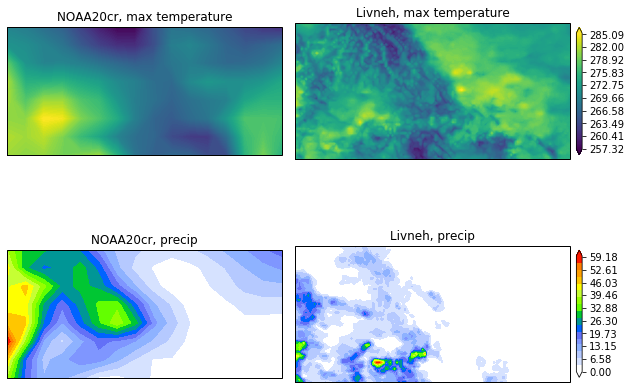

In [5]:
fig, axs, plot_fn = image_map_factory(2, 2, figsize=(6,4))
plot_fn(axs[0,0], noaa_pnw_maxt[0], noaa_pnw_pr.lat, noaa_pnw_pr.lon, title='NOAA20cr, max temperature', cmap='viridis')
cs = plot_fn(axs[0,1], livneh_pnw_maxt[0], livneh_pnw_pr.lat, livneh_pnw_pr.lon, title='Livneh, max temperature', cmap='viridis')
fig.colorbar(cs, ax=axs[0,:].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01)
plot_fn(axs[1,0], noaa_pnw_pr[0], noaa_pnw_pr.lat, noaa_pnw_pr.lon, title='NOAA20cr, precip', cmap=prcp_cmap())
cs = plot_fn(axs[1,1], livneh_pnw_pr[0], livneh_pnw_pr.lat, livneh_pnw_pr.lon, title='Livneh, precip', cmap=prcp_cmap())
fig.colorbar(cs, ax=axs[1,:].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01)

In [6]:
def evaluate_metrics_jflvm(fold, model, var='tasmax'):
    """Recomputes metrics for Glow-JFLVM (ClimAlign) on the given data fold"""
    if var == 'tasmax':
        data = maxt.preprocess_fold_maxt(fold, time_dim='time')
    elif var == 'pr':
        data = prcp.preprocess_fold_prcp(fold)
    hr_test = data.test[-1]
    test_ds = data.test_dataset(batch_size=100, buffer_size=1000,
                                map_fn_lo=upsample(hr_test.lat.size, hr_test.lon.size, method='nearest'),
                                mode='test')
    y_true = []
    y_pred = []
    for x, y in test_ds:
        y_ = model.predict_y(x)
        y_pred.append(y_)
        y_true.append(y)
    y_true = tf.concat(y_true, axis=0)
    y_pred = tf.concat(y_pred, axis=0)
    if var == 'tasmax':
        indices = tdex.indices('time', convert_units_fn=lambda x: x+273.15)
        metrics = maxt.eval_metrics(indices, y_true, y_pred, hr_test.coords, data.monthly_means[1], time_dim='time')
    elif var == 'pr':
        indices = pdex.indices('time')
        y_true, y_pred = tf.where(y_true > 1.0, y_true**3, 0.0), tf.where(y_pred > 1.0, y_pred**3, 0.0)
        metrics = prcp.eval_metrics(indices, y_true, y_pred, hr_test.coords)
    return metrics

def evaluate_metrics_bcsd(test_lr, test_hr, model, var='tasmax'):
    """Recomputes metrics for Glow-JFLVM (ClimAlign) on the given data fold"""
    y_true = tf.constant(test_hr.values, tf.float32)
    y_pred = model.predict(test_lr)
    y_pred = tf.constant(y_pred.values, dtype=tf.float32)
    if var == 'tasmax':
        indices = tdex.indices('time', convert_units_fn=lambda x: x+273.15)
        metrics = maxt.eval_metrics(indices, y_true, y_pred, test_hr.coords)
    elif var == 'pr':
        indices = pdex.indices('time')
        y_true, y_pred = tf.where(y_true > 1.0, y_true, 0.0), tf.where(y_pred > 1.0, y_pred, 0.0)
        metrics = prcp.eval_metrics(indices, y_true, y_pred, test_hr.coords)
    return metrics

def compute_metrics_maxt(hr_test, metrics):
    indices = tdex.indices('time', convert_units_fn=lambda x: x+273.15)
    txx_pred = np.array(metrics['txx'])
    txn_pred = np.array(metrics['txn'])
    txid_pred = np.array(metrics['txid'])
    txsd_pred = np.array(metrics['txsd'])
    maxt_hr_test = hr_test
    txx_true = indices.monthly_txx(maxt_hr_test)
    txn_true = indices.monthly_txn(maxt_hr_test)
    txid_true = indices.annual_icing_days(maxt_hr_test)
    txsd_true = indices.annual_summer_days(maxt_hr_test)
    txx_bias = txx_pred - txx_true.values
    txn_bias = txn_pred - txn_true.values
    txsd_bias = txsd_pred - txsd_true.values
    txid_bias = txid_pred - txid_true.values
    return txx_bias, txn_bias, txsd_bias, txid_bias

def compute_metrics_prcp(hr_test, metrics):
    from utils.metrics import correlation_metric
    indices = pdex.indices('time')
    ar20_pred = metrics['ar20'].astype(np.float64)
    prcptot_pred = metrics['atot'].astype(np.float64)
    cdd_pred = metrics['cdd'].astype(np.float64)
    cwd_pred = metrics['cwd'].astype(np.float64)
    rx1_pred = metrics['mrx1'].astype(np.float64)
    rx5_pred = metrics['mrx5'].astype(np.float64)
    sdii_pred = metrics['sdii'].astype(np.float64)
    prcp_hr_test = hr_test
    ar20_true = indices.annual_r20mm(prcp_hr_test).astype(np.float64)
    prcptot_true = indices.prcptot(prcp_hr_test).astype(np.float64)
    cdd_true = indices.cdd(prcp_hr_test).astype(np.float64)
    cwd_true = indices.cwd(prcp_hr_test).astype(np.float64)
    rx1_true = indices.monthly_rx1day(prcp_hr_test).astype(np.float64)
    rx5_true = indices.monthly_rx5day(prcp_hr_test).astype(np.float64)
    sdii_true = indices.sdii(prcp_hr_test).astype(np.float64)
    ar20_bias = ar20_pred - ar20_true.values
    prcptot_bias = prcptot_pred - prcptot_true.values
    correlation = correlation_metric()
    cdd_corr = correlation(cdd_true.values, np.array(cdd_pred)).numpy()
    cwd_corr = correlation(cwd_true.values, np.array(cwd_pred)).numpy()
    rx1_corr = correlation(rx1_true.values, np.array(rx1_pred)).numpy()
    rx5_corr = correlation(rx5_true.values, np.array(rx5_pred)).numpy()
    sdii_corr = correlation(sdii_true.values, np.array(sdii_pred)).numpy()
    return ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr, sdii_corr

In [7]:
def build_jflvm(wt_hi, ht_hi, scale, layers, depth):
    flow_hr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256), name='glow_hr'))
    flow_lr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256), name='glow_lr'))
    dx = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    dy = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    model_joint = JointFlowLVM(flow_lr, flow_hr, dx, dy,
                               Gx_aux_loss=spatial_mae(scale, stride=scale),
                               Gy_aux_loss=spatial_mae(scale),
                               input_shape=(None,wt_hi,ht_hi,1))
    return model_joint

def plot_1xn(data, title, cmin=-10., cmax=10., cmap='viridis'):
    n = len(data)
    plt.figure(figsize=(n*9,6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(data[i].numpy().squeeze(), origin='lower', cmap=cmap)
        plt.colorbar(pad=0.04, shrink=0.5)
    plt.suptitle(title, y=0.85)
    plt.show()

def upsample(new_wt, new_ht, method, scale_factor=1):
    @tf.function
    def _upsample(x):
        return tf.image.resize(x, (new_wt,new_ht), method=method) / scale_factor
    return _upsample

def spatial_mae(scale, stride=1):
    """
    "Spatial" MAE auxiliary loss for generator. Penalizes outputs
    which violate spatial average preservation between input and output.
    """
    kernel = tf.ones((scale,scale,1,1)) / (scale**2.)
    def _spatial_mse(x_in, y_pred):
        x_avg = tf.nn.conv2d(x_in, kernel, strides=(stride, stride), padding='VALID')
        y_avg = tf.nn.conv2d(y_pred, kernel, strides=(stride, stride), padding='VALID')
        return tf.math.reduce_mean(tf.math.abs(y_avg - x_avg))
    return _spatial_mse

def fit_glow_jflvm_maxt(train_lr, train_hr, test_hr, n_epochs=50, validate_freq=1, warmup=1, sample_batch_size=10, load_batch_size=1200,
                        layers=4, depth=8, min_filters=32, max_filters=256, lam=1.0, lam_decay=0.0, alpha=1.0):
    train_lr = train_lr.expand_dims(chan=1, axis=-1)
    train_hr = train_hr.expand_dims(chan=1, axis=-1)
    test_hr = test_hr.expand_dims(chan=1, axis=-1)
    N_train = train_hr.shape[0]
    N_test = test_hr.shape[0]
    (wt, ht), (wt_hi, ht_hi) = train_lr.shape[1:3], train_hr.shape[1:3]
    scale = wt_hi // wt
    train_lo, monthly_means_lo = remove_monthly_means(train_lr, time_dim='time')
    train_hi, monthly_means_hr = remove_monthly_means(train_hr, time_dim='time')
    test_hi,_ = remove_monthly_means(test_hr, monthly_means_hr, time_dim='time')
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR))
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = tf.data.Dataset.zip((train_lo_ds.shuffle(load_batch_size), train_hi_ds.shuffle(load_batch_size))).batch(sample_batch_size)
    test_ds = tf.data.Dataset.zip((train_lo_ds, test_hi_ds)).shuffle(load_batch_size).batch(sample_batch_size)
    model_joint = build_jflvm(wt_hi, ht_hi, scale, layers, depth)
    for i in range(0, n_epochs, validate_freq):
        print(f'Training joint model for {validate_freq} epochs ({i}/{n_epochs} complete)', flush=True)
        model_joint.train(train_ds, steps_per_epoch=N_train//sample_batch_size, num_epochs=validate_freq,
                          lam=lam-lam_decay*validate_freq*i, lam_decay=lam_decay, alpha=alpha)
        metrics = model_joint.evaluate(test_ds, N_test//sample_batch_size)
        model_joint.save('data/saved_models/glow-jflvm/noaa_livneh/maxt/ckpt')
        # extract and log metrics
        mlflow.log_metrics({k: v[0] for k, v in metrics.items()})
        samples_x, samples_y = model_joint.sample(n=4)
        plot_1xn(samples_x, r"Samples $x \sim P(X)$")
        plot_1xn(samples_y, r"Samples $y \sim P(Y)$")
        x_t, y_t = next(test_ds.__iter__())
        xp_t = model_joint.predict_x(y_t)
        yp_t = model_joint.predict_y(x_t)
        plot_1xn([x_t[0], y_t[0], xp_t[0], yp_t[0]], r"Predictions $X \leftrightarrow Y$")
        y_true, y_pred = [], []
        for x, y in test_ds.take(100):
            y_true.append(y)
            z, ildj = model_joint.G_zx.inverse(x)
            y_, fldj = model_joint.G_zy.forward(z)
            y_pred.append(y_)
        y_true = tf.concat(y_true, axis=0)
        y_pred = tf.concat(y_pred, axis=0)
        rmse = tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
        mlflow.log_metric('rmse', tf.math.reduce_mean(rmse).numpy())
        plt.figure(figsize=(2*8,6))
        plt.plot(range(rmse.shape[0]), rmse, c='g')
        plt.title('Validation RMSE vs time')
        plt.show()
    return model_joint

In [8]:
livneh_pnw_maxt_test = preprocess_livneh(livneh16, 'tasmax', time_st='2000-01-01', time_en='2013-12-31')

In [ ]:
with mlflow.start_run() as run:
    model = fit_glow_jflvm_maxt(noaa_pnw_maxt, livneh_pnw_maxt, livneh_pnw_maxt_test, layers=4, depth=8, lam=1.0, alpha=0.01, validate_freq=10, n_epochs=60)

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


Training joint model for 10 epochs (0/60 complete)


train:   0%|          | 0/4740 [00:00<?, ?it/s]/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):
train:  29%|██▉       | 1398/4740 [29:43<40:13,  1.38it/s, g_obj=3.69e+3, gx_loss=0.295, gy_loss=0.139, nll_x=1.25, nll_y=1.96] 

In [40]:
train_lr = noaa_pnw_maxt.expand_dims(chan=1, axis=-1)
train_hr = livneh_pnw_maxt.expand_dims(chan=1, axis=-1)
test_hr = livneh_pnw_maxt_test.expand_dims(chan=1, axis=-1)
N_test = test_hr.shape[0]
(wt, ht), (wt_hi, ht_hi) = train_lr.shape[1:3], train_hr.shape[1:3]
scale = wt_hi // wt
train_lo, monthly_means_lo = remove_monthly_means(train_lr, time_dim='time')
train_hi, monthly_means_hr = remove_monthly_means(train_hr, time_dim='time')
test_hi,_ = remove_monthly_means(test_hr, monthly_means_hr, time_dim='time')
load_batch_size = 1000
sample_batch_size = 100
train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR)).shuffle(load_batch_size)
test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size).shuffle(load_batch_size)
test_ds = tf.data.Dataset.zip((train_lo_ds, test_hi_ds)).batch(sample_batch_size)
model_maxt = build_jflvm(wt_hi, ht_hi, scale, layers=4, depth=8)
model_maxt.load('data/saved_models/glow-jflvm/noaa_livneh/maxt-2/ckpt', 9)

In [11]:
metrics_jflvm = evaluate_metrics_jflvm(((train_lr, train_hr),(train_lr,test_hr)), model_maxt)

In [12]:
txx_bias, txn_bias, txsd_bias, txid_bias = compute_metrics_maxt(test_hr, metrics_jflvm)
jflvm_metrics_arr = np.zeros((1,7,64,128))
jflvm_metrics_arr[0,:3] = metrics_jflvm['rmse'].squeeze(), metrics_jflvm['bias'].squeeze(), metrics_jflvm['corr'].squeeze()
jflvm_metrics_arr[0,3:] = np.mean(txx_bias, axis=0).squeeze(), np.mean(txn_bias, axis=0).squeeze(), \
                        np.std(txx_bias, axis=0).squeeze(), np.std(txn_bias, axis=0).squeeze()
jflvm_metrics_df = pd.DataFrame(jflvm_metrics_arr.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx bias', 'txn bias', 'txx bias std', 'txn bias std'])
jflvm_metrics_df

,rmse,bias,corr,txx bias,txn bias,txx bias std,txn bias std
0,3.254967,0.286032,0.814635,-1.833453,1.57768,2.287844,2.640926


In [41]:
# Store true values and predictions in memory
x_true = []
y_true = []
y_pred = []
for x, y in tqdm(test_ds, total=test_hr.time.size//100+1):
    y_ = model_maxt.predict_y(x)
    y_pred.append(y_)
    y_true.append(y)
    x_true.append(x)
x_true = tf.concat(x_true, axis=0)
y_true = tf.concat(y_true, axis=0)
y_pred = tf.concat(y_pred, axis=0)

100%|██████████| 52/52 [01:32<00:00,  1.79s/it]


In [42]:
t = np.random.choice(range(3650, test_hi.time.size))
x, y = x_true[t:t+1], y_true[t:t+1]

In [43]:
print(t)
print(test_hr.time[t].values)

4332
2011-11-11T00:00:00.000000000


In [44]:
y_pred = model_maxt.predict_y(x)

In [45]:
y_samples, _ = model_maxt.sample_predict_y(x, temperature=0.7, n=30)

In [46]:
x = tf.image.resize(x, (wt,ht), method='nearest')

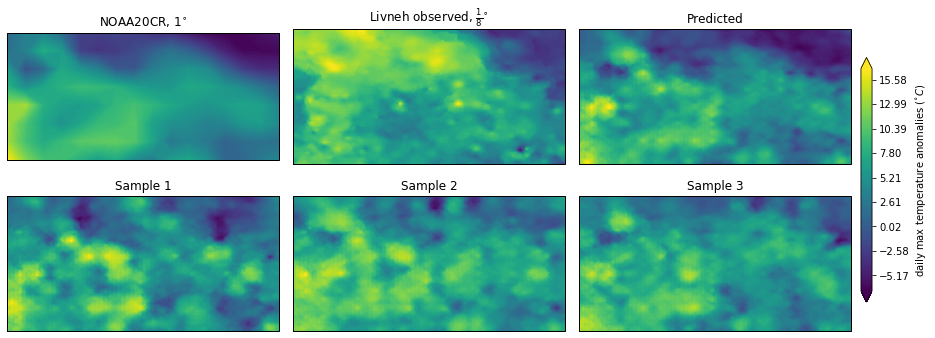

In [48]:
fig, axs, plot_fn = image_map_factory(2, 3, figsize=(6,3))
pmap = prcp_cmap()
sample_inds = np.random.choice(range(30), size=3, replace=False)
plot_fn(axs[0,0], x[0].numpy().squeeze(), train_lr.lat, train_lr.lon, title='NOAA20CR, $1^{\\circ}$', cmap='viridis')
plot_fn(axs[0,1], y[0].numpy().squeeze(), test_hr.lat, test_hr.lon, title='Livneh observed, $\\frac{1}{8}^{\\circ}$', cmap='viridis')
plot_fn(axs[0,2], y_pred[0].numpy().squeeze(), test_hr.lat, test_hr.lon, title='Predicted', cmap='viridis')
plot_fn(axs[1,0], y_samples[0,sample_inds[0]].numpy().squeeze(), test_hr.lat, test_hr.lon, title='Sample 1', cmap='viridis')
plot_fn(axs[1,1], y_samples[0,sample_inds[1]].numpy().squeeze(), test_hr.lat, test_hr.lon, title='Sample 2', cmap='viridis')
cs = plot_fn(axs[1,2], y_samples[0,sample_inds[2]].numpy().squeeze(), test_hr.lat, test_hr.lon, title='Sample 3', cmap='viridis')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.75, pad=0.01).set_label('daily max temperature anomalies ($^{\\circ}C$)')

In [65]:
metrics_bcsd = evaluate_metrics_bcsd(bcsd_test_lr.astype(np.float64), test_hr.astype(np.float64), bcsd)

bcsd pred: 100%|██████████| 366/366 [01:13<00:00,  5.00it/s]


In [66]:
txx_bias, txn_bias, txsd_bias, txid_bias = compute_metrics_maxt(test_hr, metrics_bcsd)
bcsd_metrics_arr = np.zeros((1,7,64,128))
bcsd_metrics_arr[0,:3] = metrics_bcsd['rmse'].squeeze(), metrics_bcsd['bias'].squeeze(), metrics_bcsd['corr'].squeeze()
bcsd_metrics_arr[0,3:] = np.mean(txx_bias, axis=0).squeeze(), np.mean(txn_bias, axis=0).squeeze(), \
                        np.std(txx_bias, axis=0).squeeze(), np.std(txn_bias, axis=0).squeeze()
bcsd_metrics_df = pd.DataFrame(bcsd_metrics_arr.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx bias', 'txn bias', 'txx bias std', 'txn bias std'])
bcsd_metrics_df

,rmse,bias,corr,txx bias,txn bias,txx bias std,txn bias std
0,3.005576,0.09247,0.965571,-0.93875,0.631875,2.146261,2.344995


In [ ]:
def fit_glow_jflvm_prcp(train_lr, train_hr, test_hr, n_epochs=50, validate_freq=1, warmup=1, sample_batch_size=10, load_batch_size=1200,
                        layers=4, depth=8, min_filters=32, max_filters=256, lam=1.0, lam_decay=0.0, alpha=1.0):
    import tensorflow_probability as tfp
    from normalizing_flows.models import JointFlowLVM, adversarial
    from normalizing_flows.flows import Transform, Flow, Invert
    from normalizing_flows.flows.image import Upsample
    from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
    train_lr = np.cbrt(train_lr)
    train_hr = np.cbrt(train_hr)
    test_hr = np.cbrt(test_hr)
    train_lr = xr.where(train_lr < 1.0, np.random.uniform(0.0, 1.0, size=(train_lr.time.size, train_lr.lat.size, train_lr.lon.size)), train_lr)
    train_hr = xr.where(train_hr < 1.0, np.random.uniform(0.0, 1.0, size=(train_hr.time.size, train_hr.lat.size, train_hr.lon.size)), train_hr)
    test_hr = xr.where(test_hr < 1.0, np.random.uniform(0.0, 1.0, size=(test_hr.time.size, test_hr.lat.size, test_hr.lon.size)), test_hr)
    train_lr = train_lr.expand_dims(chan=1, axis=-1)
    train_hr = train_hr.expand_dims(chan=1, axis=-1)
    test_hr = test_hr.expand_dims(chan=1, axis=-1)
    N_train = train_hr.shape[0]
    N_test = test_hr.shape[0]
    (wt, ht), (wt_hi, ht_hi) = train_lr.shape[1:3], train_hr.shape[1:3]
    scale = wt_hi // wt
    train_lo_ds = data_util.xr_to_tf_dataset(train_lr, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR)).shuffle(load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hr, load_batch_size).shuffle(load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hr, load_batch_size).shuffle(load_batch_size)
    train_ds = tf.data.Dataset.zip((train_lo_ds, train_hi_ds)).batch(sample_batch_size)
    test_ds = tf.data.Dataset.zip((train_lo_ds, test_hi_ds)).batch(sample_batch_size)
    flow_hr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256), name='glow_hr'))
    flow_lr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256), name='glow_lr'))
    dx = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    dy = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    prior = tfp.distributions.Logistic(loc=0.0, scale=1.0)
    model_joint = JointFlowLVM(flow_lr, flow_hr, dx, dy,
                               prior=prior,
                               Gx_aux_loss=spatial_mae(scale, stride=scale),
                               Gy_aux_loss=spatial_mae(scale),
                               input_shape=(None,wt_hi,ht_hi,1))
    for i in range(0, n_epochs, validate_freq):
        print(f'Training joint model for {validate_freq} epochs ({i}/{n_epochs} complete)', flush=True)
        model_joint.train(train_ds, steps_per_epoch=N_train//sample_batch_size, num_epochs=validate_freq,
                          lam=lam-lam_decay*validate_freq*i, lam_decay=lam_decay, alpha=alpha)
        metrics = model_joint.evaluate(test_ds, N_test//sample_batch_size)
        model_joint.save('data/saved_models/glow-jflvm/noaa_livneh/prcp/ckpt')
        # extract and log metrics
        mlflow.log_metrics({k: v[0] for k, v in metrics.items()})
        samples_x, samples_y = model_joint.sample(n=4)
        samples_x = tf.where(samples_x > 1.0, samples_x, 0.0)
        samples_y = tf.where(samples_y > 1.0, samples_y, 0.0)
        plot_1xn(samples_x, r"Samples $x \sim P(X)$", cmap=prcp_cmap())
        plot_1xn(samples_y, r"Samples $y \sim P(Y)$", cmap=prcp_cmap())
        x_t, y_t = next(test_ds.__iter__())
        xp_t = model_joint.predict_x(y_t)
        yp_t = model_joint.predict_y(x_t)
        x_t = tf.where(x_t > 1.0, x_t, 0.0)
        y_t = tf.where(y_t > 1.0, y_t, 0.0)
        xp_t = tf.where(xp_t > 1.0, xp_t, 0.0)
        yp_t = tf.where(yp_t > 1.0, yp_t, 0.0)
        plot_1xn([x_t[0], y_t[0], xp_t[0], yp_t[0]], r"Predictions $X \leftrightarrow Y$", cmap=prcp_cmap())
        y_true, y_pred = [], []
        for x, y in test_ds.take(100):
            y_true.append(y)
            z, ildj = model_joint.G_zx.inverse(x)
            y_, fldj = model_joint.G_zy.forward(z)
            y_pred.append(y_)
        y_true = tf.concat(y_true, axis=0)
        y_pred = tf.concat(y_pred, axis=0)
        y_true = tf.where(y_true > 1.0, tf.math.pow(y_true, 3.0), 0.0)
        y_pred = tf.where(y_pred > 1.0, tf.math.pow(y_pred, 3.0), 0.0)
        rmse = tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
        mlflow.log_metric('rmse', tf.math.reduce_mean(rmse).numpy())
        plt.figure(figsize=(2*8,6))
        plt.plot(range(rmse.shape[0]), rmse, c='g')
        plt.title('Validation RMSE vs time')
        plt.show()
    return model_joint

In [5]:
livneh_pnw_pr_test = preprocess_livneh(livneh16, 'pr', time_st='2000-01-01', time_en='2013-12-31')

In [ ]:
with mlflow.start_run() as run:
    model = fit_glow_jflvm_prcp(noaa_pnw_pr, livneh_pnw_pr, livneh_pnw_pr_test, layers=4, depth=8, lam=0.1, alpha=0.01, validate_freq=10, n_epochs=100)

In [8]:
noaa_prcp = prcp.preprocess_dataset(noaa_pnw_pr, noaa_pnw_pr.shape).expand_dims(chan=1, axis=-1)
noaa_prcp_2 = prcp.preprocess_dataset(noaa_pnw_pr_2, noaa_pnw_pr_2.shape).expand_dims(chan=1, axis=-1)
livneh_prcp = prcp.preprocess_dataset(livneh_pnw_pr, livneh_pnw_pr.shape).expand_dims(chan=1, axis=-1)
livneh_prcp_test = prcp.preprocess_dataset(livneh_pnw_pr_test, livneh_pnw_pr_test.shape).expand_dims(chan=1, axis=-1)
lr_train, lr_test, hr_train, hr_test = noaa_prcp, noaa_prcp, livneh_prcp, livneh_prcp_test
data_fold = prcp.preprocess_fold_prcp(((lr_train, hr_train),(lr_test, hr_test)))
train_lo, train_hi = data_fold.train
test_lo, test_hi = data_fold.test
N_train, N_test = train_lo.time.size, test_lo.time.size
(wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
test_ds = data_fold.test_dataset(batch_size=100, buffer_size=1000,
                                 map_fn_lo=upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR),
                                 mode='test')
model_prcp = build_jflvm(wt_hi, ht_hi, scale=8, layers=4, depth=4)
# a training anomaly seems to have occurred at around 70 epochs, so we use the iteration just before as our final model;
# this is a general problem with the architecture that needs to be investigated in the future
model_prcp.load('data/saved_models/glow-jflvm/noaa_livneh/prcp-1/ckpt', 6)
model_vars = model_prcp.trainable_variables
param_count = sum([tf.math.reduce_prod(var.shape) for var in model_vars]).numpy()
print(f'Loaded JFLVM with {param_count} trainable parameters')

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


Loaded JFLVM with 15735378 trainable parameters


In [63]:
metrics_jflvm_pr = evaluate_metrics_jflvm(((lr_train, hr_train),(lr_test,hr_test)), model_prcp, var='pr')

In [64]:
ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr, sdii_corr = compute_metrics_prcp(livneh_pnw_pr_test.expand_dims(chan=1,axis=-1), metrics_jflvm_pr)
jflvm_metrics_arr = np.zeros((1,10,64,128))
jflvm_metrics_arr[0,:3] = metrics_jflvm_pr['rmse'].squeeze(), metrics_jflvm_pr['bias'].squeeze(), metrics_jflvm_pr['corr'].squeeze()
jflvm_metrics_arr[0,3:] = np.mean(ar20_bias, axis=0).squeeze(), np.mean(prcptot_bias, axis=0).squeeze(), \
                       cdd_corr.squeeze(), cwd_corr.squeeze(), rx1_corr.squeeze(), rx5_corr.squeeze(), sdii_corr.squeeze()
jflvm_metrics_df = pd.DataFrame(jflvm_metrics_arr.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])
jflvm_metrics_df

,rmse,bias,corr,ar20 bias,prcptot bias,cdd corr,cwd corr,rx1 corr,rx5 corr,sdii corr
0,5.113316,1.035978,0.53659,-0.386091,157.037321,0.465038,0.477542,0.532877,0.616215,0.494717


In [93]:
from baselines.bcsd import BCSD
bcsd = BCSD(verbose=True, time_dim='time')
bcsd_train_lr = noaa_pnw_pr_2.expand_dims(chan=1, axis=-1)
bcsd_train_hr = livneh_pnw_pr.expand_dims(chan=1, axis=-1)
bcsd_test_lr = noaa_pnw_pr.expand_dims(chan=1, axis=-1)
bcsd_test_hr = livneh_pnw_pr_test.expand_dims(chan=1, axis=-1)
bcsd.fit(bcsd_train_lr.astype(np.float64), bcsd_train_hr.astype(np.float64))

bcsd fit: 100%|██████████| 366/366 [00:14<00:00, 25.22it/s]


In [94]:
bcsd_pred = bcsd.predict(bcsd_test_lr)

bcsd pred: 100%|██████████| 366/366 [01:12<00:00,  5.07it/s]


In [95]:
metrics_bcsd_pr = evaluate_metrics_bcsd(bcsd_test_lr.astype(np.float64), bcsd_test_hr.astype(np.float64), bcsd, var='pr')

bcsd pred: 100%|██████████| 366/366 [00:03<00:00, 121.34it/s]


In [96]:
ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr, sdii_corr = compute_metrics_prcp(livneh_pnw_pr_test.expand_dims(chan=1,axis=-1), metrics_bcsd_pr)
bcsd_metrics_arr = np.zeros((1,10,64,128))
bcsd_metrics_arr[0,:3] = metrics_bcsd_pr['rmse'].squeeze(), metrics_bcsd_pr['bias'].squeeze(), metrics_bcsd_pr['corr'].squeeze()
bcsd_metrics_arr[0,3:] = np.mean(ar20_bias, axis=0).squeeze(), np.mean(prcptot_bias, axis=0).squeeze(), \
                       cdd_corr.squeeze(), cwd_corr.squeeze(), rx1_corr.squeeze(), rx5_corr.squeeze(), sdii_corr.squeeze()
bcsd_metrics_df = pd.DataFrame(bcsd_metrics_arr.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])
bcsd_metrics_df

,rmse,bias,corr,ar20 bias,prcptot bias,cdd corr,cwd corr,rx1 corr,rx5 corr,sdii corr
0,5.697617,0.317059,0.537472,1.050773,11.576226,0.610352,0.577655,0.506829,0.623134,0.477362


In [327]:
# Store true values and predictions in memory
x_true = []
y_true = []
y_pred = []
for x, y in tqdm(test_ds, total=hr_test.time.size//100+1):
    y_ = model_prcp.predict_y(x)
    y_pred.append(y_)
    y_true.append(y)
    x_true.append(x)
x_true = tf.concat(x_true, axis=0)
y_true = tf.concat(y_true, axis=0)
y_pred = tf.concat(y_pred, axis=0)

100%|██████████| 52/52 [00:51<00:00,  1.00it/s]


In [328]:
y_true = tf.where(y_true > 1.0, y_true**3, 0.0).numpy()
y_pred = tf.where(y_pred > 1.0, y_pred**3, 0.0).numpy()

In [129]:
climatology_metrics = np.zeros((2,4))
# climatology bias
climatology_metrics[0,0] = np.mean((np.mean(y_pred, axis=0) - np.mean(y_true, axis=0)))
climatology_metrics[1,0] = np.mean(np.mean(bcsd_pred.values.astype(np.float32), axis=0) - np.mean(y_true, axis=0))
climatology_metrics[0,1] = np.mean((np.quantile(y_pred[y_pred > 0], 0.5, axis=0) - np.quantile(y_true[y_true > 0], 0.5, axis=0)))
climatology_metrics[1,1] = np.mean((np.quantile(bcsd_pred.values[bcsd_pred > 0], 0.5, axis=0) - np.quantile(y_true[y_true > 0], 0.5, axis=0)))
climatology_metrics[0,2] = np.mean((np.quantile(y_pred[y_pred > 0], 0.98, axis=0) - np.quantile(y_true[y_true > 0], 0.98, axis=0)))
climatology_metrics[1,2] = np.mean((np.quantile(bcsd_pred.values[bcsd_pred > 0], 0.98, axis=0) - np.quantile(y_true[y_true > 0], 0.98, axis=0)))
climatology_metrics[0,3] = np.mean((np.quantile(y_pred[y_pred > 0], 0.02, axis=0) - np.quantile(y_true[y_true > 0], 0.02, axis=0)))
climatology_metrics[1,3] = np.mean((np.quantile(bcsd_pred.values[bcsd_pred > 0], 0.02, axis=0) - np.quantile(y_true[y_true > 0], 0.02, axis=0)))
climatology_metrics_df = pd.DataFrame(climatology_metrics, index=['JFLVM', 'BCSD'], columns=['climatology bias', 'p50 bias', 'p98 bias', 'p02 bias'])

In [130]:
climatology_metrics_df

,climatology bias,p50 bias,p98 bias,p02 bias
JFLVM,0.527468,0.411823,-3.457142,0.008887
BCSD,0.229542,-2.370754,-4.184608,-1.047102


In [161]:
t = 4681
t = #np.random.choice(range(3650, noaa_prcp.time.size))
x, y = x_true[t:t+1], y_true[t:t+1]

In [162]:
print(t)
print(noaa_prcp.time[t].values, livneh_prcp_test.time[t].values)

4681
2012-10-25T00:00:00.000000000 2012-10-25T00:00:00.000000000


In [163]:
y_pred = model_prcp.predict_y(x)

In [164]:
y_samples, _ = model_prcp.sample_predict_y(x, temperature=0.7, n=30)

In [165]:
x = tf.where(x > 1.0, x**3, 0.0)
x = tf.image.resize(x, (wt,ht), method='nearest')
y_pred = tf.where(y_pred > 1.0, y_pred**3, 0.0)
y_samples = tf.where(y_samples > 1.0, y_samples**3, 0.0)

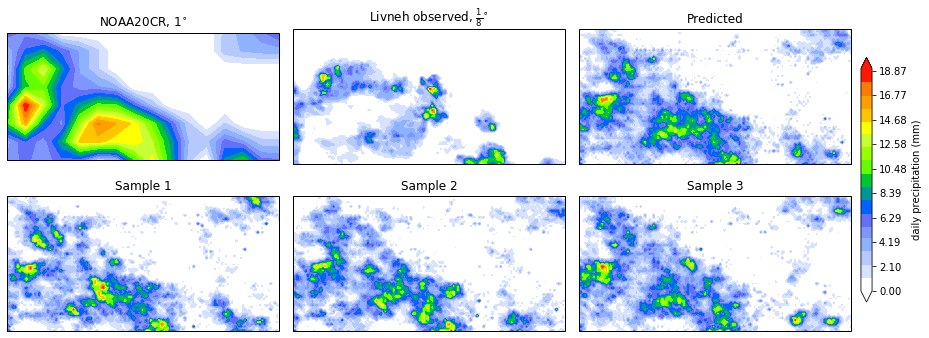

In [166]:
fig, axs, plot_fn = image_map_factory(2, 3, figsize=(6,3))
pmap = prcp_cmap()
sample_inds = np.random.choice(range(30), size=3, replace=False)
plot_fn(axs[0,0], x[0].numpy().squeeze(), noaa_prcp.lat, noaa_prcp.lon, title='NOAA20CR, $1^{\\circ}$', cmap=pmap)
plot_fn(axs[0,1], y[0].squeeze(), livneh_prcp.lat, livneh_prcp.lon, title='Livneh observed, $\\frac{1}{8}^{\\circ}$', cmap=pmap)
plot_fn(axs[0,2], y_pred[0].numpy().squeeze(), livneh_prcp.lat, livneh_prcp.lon, title='Predicted', cmap=pmap)
plot_fn(axs[1,0], y_samples[0,sample_inds[0]].numpy().squeeze(), livneh_prcp.lat, livneh_prcp.lon, title='Sample 1', cmap=pmap)
plot_fn(axs[1,1], y_samples[0,sample_inds[1]].numpy().squeeze(), livneh_prcp.lat, livneh_prcp.lon, title='Sample 2', cmap=pmap)
cs = plot_fn(axs[1,2], y_samples[0,sample_inds[2]].numpy().squeeze(), livneh_prcp.lat, livneh_prcp.lon, title='Sample 3', cmap=pmap)
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.75, pad=0.01).set_label('daily precipitation (mm)')

In [342]:
def monthly_precip(indices, data):
    #data_arr = xr.DataArray(data.numpy(), coords=coords)
    data_ind = indices.monthly_rx5day(data)
    return data_ind

In [349]:
indices = pdex.indices('time')
livneh_old = monthly_precip(indices, livneh_pnw_pr).mean(dim=['lat','lon'])
livneh_new = monthly_precip(indices, livneh_pnw_pr_test).mean(dim=['lat','lon'])
pred_new = monthly_precip(indices, xr.DataArray(y_pred, coords=livneh_prcp_test.coords)).mean(dim=['lat','lon'])

In [321]:
# Store true values and predictions in memory
data_fold_noaa99 = prcp.preprocess_fold_prcp(((lr_train, hr_train),(noaa_prcp_2, hr_test)))
test_ds_noaa99 = data_fold_noaa99.test_dataset(batch_size=100, buffer_size=1000,
                                 map_fn_lo=upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR),
                                 mode='test')
x_true = []
y_true = []
y_pred_noaa99 = []
for x, y in tqdm(test_ds_noaa99, total=noaa_prcp_2.time.size//100+1):
    y_ = model_prcp.predict_y(x)
    y_pred_noaa99.append(y_)
    y_true.append(y)
    x_true.append(x)
x_true = tf.concat(x_true, axis=0)
y_true = tf.concat(y_true, axis=0)
y_pred_noaa99 = tf.concat(y_pred_noaa99, axis=0)
y_true = tf.where(y_true > 1.0, y_true**3, 0.0).numpy()
y_pred_noaa99 = tf.where(y_pred_noaa99 > 1.0, y_pred_noaa99**3, 0.0).numpy()

100%|██████████| 48/48 [00:47<00:00,  1.00it/s]


In [344]:
pred_old = monthly_precip(indices, xr.DataArray(y_pred_noaa99, coords=livneh_prcp.coords)).mean(dim=['lat','lon'])

In [350]:
x1 = np.array(range(livneh_old.time.size))
x2 = np.array(range(livneh_new.time.size))

In [354]:
df1 = pd.DataFrame.from_dict({i: livneh_old[i] for i in x1}, orient='index', columns=['pr']).reset_index()
df1['Source'] = 'Livneh 87-99'
df2 = pd.DataFrame.from_dict({i: livneh_new[i] for i in x2}, orient='index', columns=['pr']).reset_index()
df2['Source'] = 'Livneh 00-13'
df3 = pd.DataFrame.from_dict({i: pred_old.values[i] for i in x1}, orient='index', columns=['pr']).reset_index()
df3['Source'] = 'ClimAlign/NOAA 87-99'
df4 = pd.DataFrame.from_dict({i: pred_new.values[i] for i in x2}, orient='index', columns=['pr']).reset_index()
df4['Source'] = 'ClimAlign/NOAA 00-13'
df = pd.concat([df1,df3,df2,df4],axis=0)

In [355]:
df

,index,pr,Source
0,0,21.732975,Livneh 87-99
1,1,21.404144,Livneh 87-99
2,2,31.889194,Livneh 87-99
3,3,18.627584,Livneh 87-99
4,4,33.279995,Livneh 87-99
...,...,...,...
163,163,20.893642,ClimAlign/NOAA 00-13
164,164,39.819187,ClimAlign/NOAA 00-13
165,165,33.465290,ClimAlign/NOAA 00-13
166,166,30.964565,ClimAlign/NOAA 00-13


Text(0, 0.5, 'Monthly average 5-day precip. (mm)')

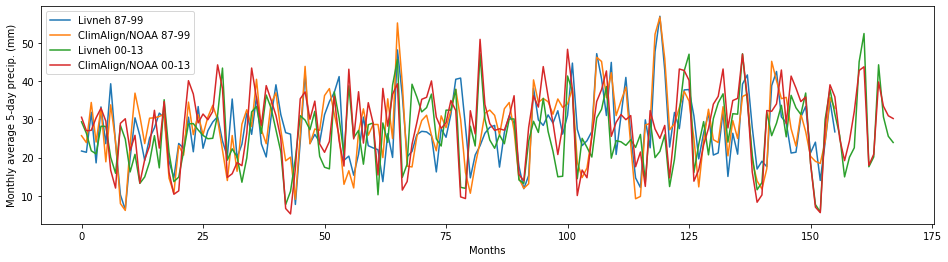

In [368]:
plt.figure(figsize=(16,4))
ax = sns.lineplot(data=df, x='index', y='pr', hue='Source')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_xlabel('Months')
ax.set_ylabel('Monthly average 5-day precip. (mm)')